# Some words here

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
import pandas as pd
import numpy.random as rand

from mpl_toolkits.mplot3d import Axes3D
from IPython.core.display import HTML
import matplotlib.font_manager
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm

import matplotlib.contour as contour
from matplotlib import cm, ticker
import matplotlib as mpl

#from System import System #custom class

In [2]:
import matplotlib.cm as cmx
colors = [(0.03622706206371584, 0.34758778627580533, 0.01986544244584898), #dark green
         (0.6053728047696756, 0.12285060981191465, 0.33668767700053526), #dark red
         (0.2962116999036982, 0.32094848866668646, 0.9759888514083577), #pretty blue
         (0.039492199876027034, 0.6074865840810965, 0.5673421818210376), #pretty teal
         (0.9664233468923764, 0.22096743571225297, 0.11020477132985629), #coral
         (0.3,0.3,0.4)] #gray

# Start Functions

In [3]:
def PlotStyle():
    font = {'size':14,  
            'family':'DejaVu Sans', 
           'weight': 'normal'}
    axis = {'labelsize':18, 
           'titlesize':12, 
           'labelpad':18, 
           'labelweight': 'normal', 
           'linewidth': 0.5}
    xtick = {'labelsize': 12}
    ytick = {'labelsize':12}
    legend = {'fontsize':'large',
              'framealpha':0.0}
    figure_sp = {'hspace':0.3}
    axes = {'formatter.use_mathtext':False}
    mathtext = {'fontset':'dejavusans'}
    text = {'usetex': False,
           'latex.unicode':False}
    plt.rc('axes', **axes)
    plt.rc('mathtext', **mathtext)
    plt.rc('axes', **axis);plt.rc('font', **font);plt.rc('xtick', **xtick); plt.rc('ytick', **ytick)
    plt.rc('figure.subplot', **figure_sp);plt.rc('legend', **legend)
    #plt.rc('text', **text)
    

In [4]:
def SetAxis(ax, x,y,title = '', args = {'fontsize': 18}):
    ax.set_xlabel(x, **args)
    ax.set_ylabel(y, **args)
    ax.set_title(title, **args)

In [5]:
import time

def starttimer():
    global starttime
    starttime = time.time()
def endtimer():
    endtime = time.time()
    runtime = endtime-starttime
    if(runtime > 60):
        runmins = int(runtime/60)
        runsecs = runtime - runmins * 60
        print("Runtime : %d min %.5f secs "%(runmins, runsecs))
    else:
        print("Runtime : %.5f secs"%runtime)
def ProgressBar(index, array, sep = "\n"):
    total = len(array)
    progress = (index/total)*100
    steps = [10*(i+1) for i in range(10)]
    if(progress in steps):
        print(r"%.1f%% done   "%(progress), end = sep)
    

In [6]:
# a new class for photodetectors
class PhotoDetector:
    InitOpts = {'RtrnOps':
                    {'indices':'all', 'opts':['spsm', 'nphot']}}
    defaults = \
        {'N':6, #number of spin sites (length of chain)
         'M':10, #number of cavity occupation states
         'J':.1*2*np.pi, #spin-spin coupling 
         'g':.5, #spin-cavity coupling
         'pump1':.1, #first site pumping rate 
         'gammaN':.1, #terminal site spin dissipation
         'kappa':.3} #cavity dissipation 
     
    def __init__(self, pdict = defaults, makeH = True, GetInfo = False, kind = "II", initopts = None):
        if(initopts == None): initopts = PhotoDetector.InitOpts
    # define parameters with defaults
        defp = PhotoDetector.defaults.copy()
    # update with given dict, pdict
        self.defdict = defp.copy()      # first, set to defaults (avoiding changing defaults)
        for p in pdict: 
            if(p in defp): 
                self.defdict.update({p:pdict.get(p)})
        self.N, self.M, self.J, self.g,\
        self.pump1, self.gammaN, self.kappa = (self.defdict.get(i) for i in self.defdict)
    
    # update again for specificed system type
        self.SysUpdate(kind = kind)
        
    # prepare operator lists
        si = qeye(2)
        sx = sigmax()
        sy = sigmay()
        sz = sigmaz()
        sm = destroy(2)
        sp = create(2)
        bi = qeye(self.M)
        
        self.si_list, self.sx_list, self.sy_list, self.sz_list, self.sp_list, self.sm_list = ([] for _ in range(6))
        
        for n in range(self.N):
            op_list = []
            for m in range(self.N):
                op_list.append(si)
          
            if(self.M>0): op_list.append(bi)   

            op_list[n] = sx
            self.sx_list.append(tensor(op_list))

            op_list[n] = sy
            self.sy_list.append(tensor(op_list))

            op_list[n] = sz
            self.sz_list.append(tensor(op_list))

            op_list[n] = sp
            self.sp_list.append(tensor(op_list))

            op_list[n] = sm
            self.sm_list.append(tensor(op_list))
            
            op_list[n] = si
        
    # cavity mode operator
        if(self.M>0):
            aop = destroy(self.M)
            op_list[self.N] = aop
            self.a = tensor(op_list)
            
    # other default parameters
        self.n_th = 0.0 #for thermal bath
        self.w0 = 1.0*2*np.pi #atom frequency
        self.omegac = self.w0 #cavity frequency
        self.H = 0
        self.tdepargs = 0
        
    # set default J_lists
        self.setJconst(self.J, self.J, 0)
        
    # set default c_ops
        self.c_ops = []
        self.gamma = self.VariantCOp(-1, self.gammaN, self.sm_list)
        self.pump = self.VariantCOp(0, self.pump1, self.sp_list)
        if(self.M>0): self.kappa = self.VariantCOp(0, self.kappa, self.a)
        
    # set default r_ops : N sz ops and (if cavity) a^{\dag} a  
        self.r_ops = []
        self.RtrnOps(**initopts['RtrnOps'])
        
    # set initial state
        self.SetPsi0()
        
    # construct Hamiltonian
        if(makeH): self.ConstructH()
    
        if(GetInfo): self.GetInfo()
        
        
     #-----------------------------------  end of __init__   ------------------------------------------------   
    #adjust dictionary for specific system
    def SetParamfromDict(self, usedict):
        self.N, self.M, self.J, self.g, \
        self.pump1, self.gammaN, self.kappa = (usedict.get(i) for i in usedict)
        
    def SysUpdate(self,kind):
        if(kind not in ["I", "II", "III"]): print("SysUpdate: given 'kind' not compatible, (options are 'I', 'II', 'III')")
        ndict = self.defdict.copy()
        if(kind == "I"):
            ndict.update(M=0) 
        if(kind == "II"):
            if not isinstance(ndict['g'], (int, float)): print("warning: g has not been reset to single val"); ndict.update(g = 0.001)
        if(kind == "III"):
            if not isinstance(ndict['g'], (int,float)): print("warning: g has not been reset to single val"); ndict.update(g = 0.001)
            gtemp = [0,]*(self.N-1)+[self.g]
            ndict.update(g = gtemp)
        
        self.defdict = ndict.copy()
        self.SetParamfromDict(ndict)
    
    def setJconst(self, jx, jy, jz):
        self.Jx = jx *np.ones(self.N)
        self.Jy = jy  *np.ones(self.N)
        self.Jz = jz  *np.ones(self.N)
        
    #FOR TIME-INDEPENDENT COLLAPSE OPERATORS
    def VariantCOp(self, indices, vals, oplist): 
        # indices : location in array where collapse coefficient is nonzero
        # vals : values correspoding to indices
        arr = np.zeros(self.N)
        
        #given a single operator (ex: cavity operator)
        if not isinstance(oplist, (list, np.ndarray)):
            if isinstance(indices, (int, float)) and isinstance(vals, (int,float)):
                self.c_ops.append(np.sqrt(vals)*oplist)
                return vals
            
        
        #given list of indices
        if(isinstance(indices, (list, np.ndarray))):
            if len(indices)>len(oplist):
                print("VariantCOp: indices list larger than oplist"); return None
            
            if isinstance(vals, (int, float)): 
                # same val for all indices
                for i in range(len(indices)):
                    arr[indices[i]] = vals
                    self.c_ops.append(np.sqrt(vals)*oplist[i])
                    
            elif isinstance(vals, (list, np.ndarray)): 
                #list of values corresponding to indices
                if (len(indices)!=len(vals)) or (len(indices)>self.N):
                    print("VariantCOp: specificed nonzero indices and/or nonzero values have incorrect shape")
                    return None
                else:
                    for i in range(len(indices)):
                        arr[indices[i]] = vals[i]
                        self.c_ops.append(np.sqrt(vals[i])*oplist[i])
            else: 
                print("Don't understand vals type")
                return None
            
        #given a single indice
        elif isinstance(indices, (int, float)): 
            
            if isinstance(vals, (int,float)): 
                # must be given single value
                arr[indices] = vals
                self.c_ops.append(np.sqrt(vals)*oplist[indices])
                
            else: 
                print("VariantCOp: indices is an int or float, vals must also be an int or float")
                return None
        
        return arr #returns the c_op coefficients as an array 

    def TDepPump(self,func, args = 0):
        self.tdepargs = args
        c_ops = []
        c_ops.append(self.c_ops[0]) #gamma
        if(self.M>0): c_ops.append(self.c_ops[2]) #kappa
        c_ops.append([self.sp_list[0], func])
        self.c_ops = c_ops
            
    def RtrnOps(self, indices = 'all', opts = ['sz', 'nphot']):
        # indices: 'all' or [list of values] for spin sites,      opts: 'opt' or [list of 'opt'] 
        # possible opts:     'nphot' - include a^{\dagger} a     'sz'/'spsm'- type of spin expectation    
        
        #make non-list type indices iterable
        if(indices == 'all'):
            indices = range(self.N) 
        if(isinstance(indices, int) or isinstance(indices, float)):
            indices = [indices]

        for n in indices:
            if('sz' in opts): 
                self.r_ops.append(self.sz_list[n])
            if('spsm' in opts): 
                self.r_ops.append(self.sp_list[n]*self.sm_list[n])

        #cavity expectation
        if(self.M>0 and ('nphot' in opts)):
            self.r_ops.append(self.a.dag()*self.a)
    
    def SetPsi0(self,first = 'excited'):
        psi_list = []
        
        if(first == 'excited'):
            psi_list.append(basis(2,1))
        elif(first == 'ground'):
            psi_list.append(basis(2,0))
        for n in range(self.N-1):
            psi_list.append(basis(2,0))
        
        if(self.M>0):
            psi_list.append(basis(self.M))
        
        psi0 = tensor(psi_list)
        self.psi0 = psi0
        
    def ConstructH(self): 
        
        H = 0
            
        for n in range(self.N):
            H += - 0.5 * self.w0 * self.sz_list[n] 
            
        for n in range(self.N-1):
            H += - 0.5 * self.Jx[n] * self.sx_list[n] * self.sx_list[n+1]
            H += - 0.5 * self.Jy[n] * self.sy_list[n] * self.sy_list[n+1]
            H += - 0.5 * self.Jz[n] * self.sz_list[n] * self.sz_list[n+1]
            
        if(self.M>0): 
            H += self.omegac*self.a.dag()*self.a
            
            for n in range(self.N): 
                if isinstance(self.g, (int, float)): # if g is a single value, assumes inform coupling
                    H+= self.g * (self.a.dag() * self.sm_list[n] + self.sp_list[n]*self.a)
                elif isinstance(self.g, (list, np.ndarray)): # if g is list, must be same size as N
                    if len(self.g) != len(self.sm_list): print("ConstructH: g improper length")
                    H+= self.g[n] * (self.a.dag() * self.sm_list[n] + self.sp_list[n]*self.a)
                
        self.H = H
    
    def expectH(self, tlist = np.linspace(0,50,200), rtrnopt = 'expect', \
                solver = 'mcsolve', ntraj = 500, odeopts = {}, verbose = False, reuse = False): #time evolve hamiltonian
        
        #set solver options
        solveopts = {}
        if(verbose):
            solveopts.update(progress_bar = True)
        else: 
            solveopts.update(progress_bar = None)
        if (solver == 'mcsolve'):
            solveopts.update(ntraj = ntraj)
        if(self.tdepargs !=0):     # if a time-dependent function with arguments is defined, include args in solve()
            solveopts.update(args = self.tdepargs)
            if(verbose): print(solveopts['args'])
            
        if(len(odeopts)>0):
            if(solver !='mcsolve'): print("odeopts only set up for mcsolve, must go in and add to class")
            else:
                opts = Options(**odeopts)
                print("solving with options. Dictionary:", odeopts)
                result = mcsolve(self.H, self.psi0, tlist, self.c_ops, self.r_ops,options = opts,**solveopts)
                return result
                
        if(solver == 'mesolve'):
            print("mesolving...")
            result = mesolve(self.H, self.psi0, tlist, self.c_ops, self.r_ops,**solveopts)
            if not verbose: print("done")
        elif(solver == 'mcsolve'):
            print("mcsolving...")
            result = mcsolve(self.H, self.psi0, tlist, self.c_ops, self.r_ops,**solveopts)
            if not verbose: print("done")
        elif(solver == 'steadystate'):
            print("finding steadystate...", end = '\t')
            rho = steadystate(self.H, self.c_ops)
            result = [expect(op,rho) for op in self.r_ops]
            print("done")
            
        return result
    
                
    def GetInfo(self):
        lname = ["N", "M", "Jx", "Jy", "Jz", "gamma", "pump","num spin collapse ops", "num return ops", "H dims", "coupling, g", "kappa"]
        infolist = [self.N, self.M, self.Jx, self.Jy, self.Jz, self.gamma, self.pump,len(self.c_ops), len(self.r_ops), self.H.shape]
        if(self.M>0): 
            infolist+= [self.g,self.kappa]
            
        for ind,i in enumerate(infolist):
            width = max(len(n) for n in lname)
            print(lname[ind], end = ' '*(width - len(lname[ind])+3))
            if(isinstance(i,float)): print('%.3g'%i)
            elif(isinstance(i, int)): print('%d'%i)
            elif(isinstance(i, str)): print('%s'%i)
            elif(isinstance(i, np.ndarray)):
                if(i[0]==i[-1]): #same value repeating
                    if(isinstance(i[0],float)): print("[%.3f, ....]"%i[0])
                    elif(isinstance(i[0], int)): print("[%d, ....]"%i[0])
                else:
                    print(i)
            elif(isinstance(i, list)):
                if(i[0]==i[-1]): #same value repeating
                    if(isinstance(i[0],float)): print("[%.3f, ....]"%i[0])
                    elif(isinstance(i[0], int)): print("[%d, ....]"%i[0])
                else:
                    print(i)
            else:
                print(i)

        
    

In [7]:
import scipy.stats as scistat
def GetStats(data):
        mu = np.mean(data)
        var = np.var(data)
        skew = scistat.skew(data)
        kurt = scistat.kurtosis(data)
        stdev = np.sqrt(var)
        n = len(data)
        return n, mu, var, skew, kurt

def timediffs(arr):
    outcol = [val for row in arr for val in row]
    outdiff = []
    for row in arr:
        ind = 0
        while((ind+1)<len(row)):
            outdiff.append(row[ind+1]-row[ind]); ind+=1
    return outcol, outdiff
    
def WaitTimes(expt, order = 'gpk'):
    times = expt.col_times
    which = expt.col_which
    origdf = pd.DataFrame(np.vstack([times,which]).T)
    origarr = origdf.values
    itimes, iwhich = [int(0),int(1)]
    if(order ==  'gpk'):
        gamtime, pumptime,kaptime = [np.asarray([origarr[n][itimes][origarr[n][iwhich]==i] for n in range(len(origarr))]) for i in range(3)]
    elif(order == 'kgp'):
        kaptime,gamtime,pumptime = [np.asarray([origarr[n][itimes][origarr[n][iwhich]==i] for n in range(len(origarr))]) for i in range(3)]
    elif(order == 'gkp'):
        gamtime,kaptime,pumptime = [np.asarray([origarr[n][itimes][origarr[n][iwhich]==i] for n in range(len(origarr))]) for i in range(3)]    
    colgamma, gtimediffs  = timediffs(gamtime)    
    colpump, ptimediffs  = timediffs(pumptime)
    colkappa, ktimediffs  = timediffs(kaptime)
    return gtimediffs, ptimediffs, ktimediffs, colgamma,colpump, colkappa

class CollapseFuncs:
    
    def __init__(self, expt, order = 'gpk'):
        self.colors = ["green", "red", "blue"]
        self.gtimediffs, self.ptimediffs, self.ktimediffs, self.colgamma, self.colpump, self.colkappa = WaitTimes(expt, order)      
    def Namecolors(self, clist = ["green", "red", "blue"]):
        self.colors = clist
    def PlotColTimes(self,ax = None, histopts = None):      
        if(isinstance(ax, type(None))): fig, ax = plt.subplots(figsize = (15,6))
        if isinstance(histopts, type(None)): histopts = {'bins':50, 'histtype':'step'}
        _ = ax.hist(self.colpump, label = 'initial site pumping', color= self.colors[0],**histopts)
        _ = ax.hist(self.colgamma,label = 'terminal site emission',color = self.colors[1],**histopts)
        _ = ax.hist(self.colkappa, label = 'cavity dissipation', color = self.colors[2], **histopts)
        ax.set_xlabel("Time of Collapse")
        ax.set_ylabel("Frequency")
    
    def PlotWaitTimes(self,ax = None, histopts = None):
        if(isinstance(ax, type(None))): fig, ax = plt.subplots(figsize = (15,6))
        if isinstance(histopts, type(None)): histopts = {'bins':50, 'histtype':'step'}
        _ = ax.hist(self.ptimediffs,color = self.colors[0],label = 'inital site pumping', **histopts)
        _ = ax.hist(self.gtimediffs, color = self.colors[1], label = 'terminal site emission', **histopts)
        _ = ax.hist(self.ktimediffs,color =  self.colors[2], label = 'cavity dissipation', **histopts)
        ax.legend()
        ax.set_xlabel("Time between collapses")
        ax.set_ylabel("Frequency")
    
    def Plot(self, ax = None, histopts = None):
        if(isinstance(ax, type(None))): fig, ax = plt.subplots(1,2,figsize = (15,6))
        self.PlotColTimes(ax = ax[0], histopts = histopts)
        self.PlotWaitTimes(ax = ax[1], histopts = histopts)
        
    def GetStats(self):
        return [GetStats(arr) for arr in [self.gtimediffs,self.ptimediffs,self.ktimediffs]]
    

# End Functions<br><br><br><br>
## Characterizing  Systems $\mathrm{I}-\mathrm{III}$ : *Expected Values*

In [8]:
pdict = PhotoDetector.defaults.copy()
pdict.update(J = 0.5)
PhotoDetector.InitOpts

{'RtrnOps': {'indices': 'all', 'opts': ['spsm', 'nphot']}}

In [9]:
sys1 = PhotoDetector(pdict, kind = 'I')
sys2 = PhotoDetector(pdict, kind = 'II')
sys3 = PhotoDetector(pdict, kind = 'III')
_ = [sys.GetInfo() for sys in [sys1,sys2,sys3]]

N                       6
M                       0
Jx                      [0.500, ....]
Jy                      [0.500, ....]
Jz                      [0.000, ....]
gamma                   [0.  0.  0.  0.  0.  0.1]
pump                    [0.1 0.  0.  0.  0.  0. ]
num spin collapse ops   2
num return ops          6
H dims                  (64, 64)
N                       6
M                       10
Jx                      [0.500, ....]
Jy                      [0.500, ....]
Jz                      [0.000, ....]
gamma                   [0.  0.  0.  0.  0.  0.1]
pump                    [0.1 0.  0.  0.  0.  0. ]
num spin collapse ops   3
num return ops          7
H dims                  (640, 640)
coupling, g             0.5
kappa                   0.3
N                       6
M                       10
Jx                      [0.500, ....]
Jy                      [0.500, ....]
Jz                      [0.000, ....]
gamma                   [0.  0.  0.  0.  0.  0.1]
pump                  

In [10]:
t = np.linspace(0,50,200)
r_I, r_II, r_III = [sys.expectH(t, verbose = True, ntraj = 1000) for sys in [sys1, sys2, sys3]]

mcsolving...
10.0%. Run time:   1.40s. Est. time left: 00:00:00:12
20.0%. Run time:   2.33s. Est. time left: 00:00:00:09
30.0%. Run time:   3.29s. Est. time left: 00:00:00:07
40.0%. Run time:   4.28s. Est. time left: 00:00:00:06
50.0%. Run time:   5.24s. Est. time left: 00:00:00:05
60.0%. Run time:   6.13s. Est. time left: 00:00:00:04
70.0%. Run time:   7.02s. Est. time left: 00:00:00:03
80.0%. Run time:   7.91s. Est. time left: 00:00:00:01
90.0%. Run time:   8.84s. Est. time left: 00:00:00:00
100.0%. Run time:   9.84s. Est. time left: 00:00:00:00
Total run time:   9.93s
mcsolving...
10.0%. Run time:   3.22s. Est. time left: 00:00:00:29
20.0%. Run time:   5.55s. Est. time left: 00:00:00:22
30.0%. Run time:   8.05s. Est. time left: 00:00:00:18
40.0%. Run time:  10.72s. Est. time left: 00:00:00:16
50.0%. Run time:  13.30s. Est. time left: 00:00:00:13
60.0%. Run time:  15.89s. Est. time left: 00:00:00:10
70.0%. Run time:  18.42s. Est. time left: 00:00:00:07
80.0%. Run time:  20.98s. Est. 

In [35]:
expts1, expts2, expts3 = [result.expect for result in [r_I, r_II, r_III]]

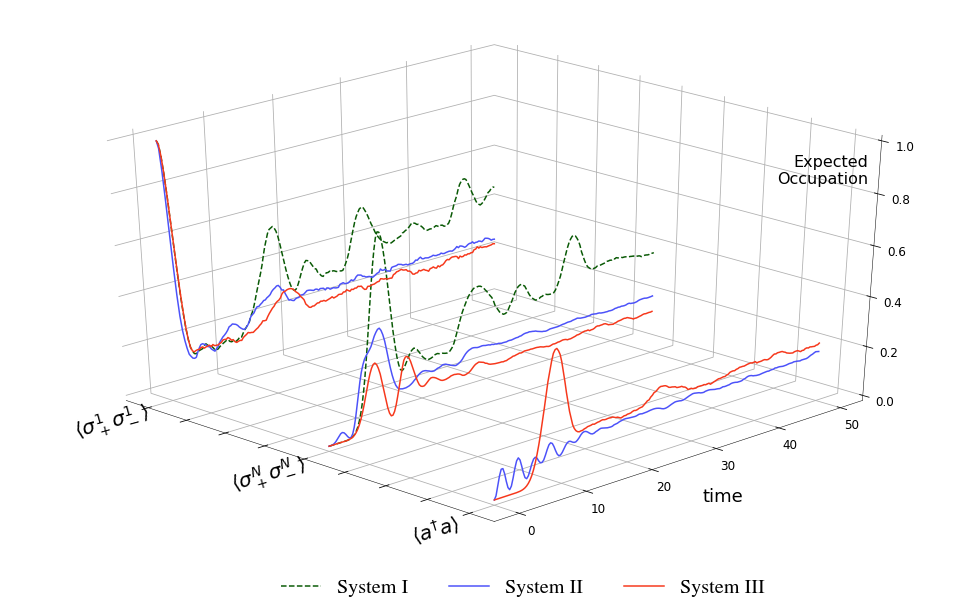

In [40]:
PlotStyle()
t = np.linspace(0,50,200)
def func3D(ax, expts_s, color = None, zpos = None, label = '', sel = None, plotopts = {}):
    if zpos == None: zpos = np.arange(1,len(expts_s)+1)
    if sel != None: expts_s = [expts_s[i] for i in sel]
    if isinstance(color, type(None)): 
        color = (rand.random(), rand.random(), rand.random())
        storecolors.append(color)
    for ind, expt in enumerate(expts_s): #ex: init, terminal, and cavity
        z = zpos[ind]*np.ones(len(t))
        if(ind == 0): #only add one legend entry per system
            ax.plot(z,t,expt, color = color, label = label, **plotopts)
        else:
            ax.plot( z, t,  expt, color = color, **plotopts)


fig = plt.figure(figsize = (17,10))
ax = fig.add_subplot(111, projection='3d')
sel = [0,-2,-1]
func3D(ax,expts1,  color = colors[0], label = "System I", sel = [0,-1], plotopts = {'linestyle':"--"})
func3D(ax,expts2,  color = colors[2], label = "System II", sel = sel)
func3D(ax,expts3,  color = colors[4], label = "System III", sel = sel)
ax.legend(loc = (.28,-.1), fontsize = 25, ncol = 3, prop = {'family':'StixGeneral', 'size':'x-large'})

ax.view_init(30,-45) #elevation, rotation
textopts = {'fontsize':20, 'color':'black', 'verticalalignment':'center', 'horizontalalignment':'center'} 
ax.set_ylabel("time")
ax.tick_params("x", labelbottom = False)
ax.text3D(1.1,-11, 0,r"$\langle \sigma_+^{1} \sigma_-^{1}\rangle$",zdir = (.5,40,0),**textopts)
ax.text3D(2.1,-11, 0,r"$\langle \sigma_+^{N} \sigma_-^{N}\rangle$", zdir = (.5,40,0),**textopts)
ax.text3D(3.1,-11, 0,r"$\langle a^{\dagger} a \rangle$", zdir = (.5,40,0),**textopts)
ax.text3D(3.28,48, .9,"Expected\nOccupation", horizontalalignment = 'right', fontsize = 16, zdir = (0,0,0))

ax.xaxis.set_pane_color((1.0,1.0,1.0))
ax.yaxis.set_pane_color((1.0,1.0,1.0))
ax.zaxis.set_pane_color((1.0,1.0,1.0))

# ax.set_facecolor('#2d2d2e')
# fig.set_facecolor('#2d2d2e')
# ax.xaxis._axinfo['tick']['color'] = 'white'
# ax.yaxis._axinfo['tick']['color'] = 'white'
# ax.zaxis._axinfo['tick']['color'] = 'white'
# ax.xaxis._axinfo['label']['color'] = 'white'
# ax.yaxis._axinfo['label']['color'] = 'white'
# ax.zaxis._axinfo['label']['color'] = 'white'
# ax.tick_params(colors = 'white')
# ax.grid()
plt.savefig("posterplots/exptbox.png")

## Characterizing  Systems $\mathrm{I}-\mathrm{III}$ : *Collapse Wait Times*

<br> **check** : $\mathrm{t_{\,final}} = 30$ to see $\mathrm{Sys.\;III}$ cavity wait times <br><br>

In [9]:
pdict = PhotoDetector.defaults.copy()
pdict.update(J = 0.5)
#pdict

sysI = PhotoDetector(pdict, kind = "I")
sysII = PhotoDetector(pdict, kind = "II")
sysIII = PhotoDetector(pdict, kind = "III")

# for ind, sys in enumerate([sysI, sysII, sysIII]):
#     print("System" + ["I", "II", "III"][ind]+"\n")
#     sys.GetInfo(); print("\n")

In [10]:
t = np.linspace(0,50,200)
r_I, r_II, r_III = [sys.expectH(t, verbose = True, ntraj = 1000) for sys in [sysI, sysII, sysIII]]

mcsolving...
10.0%. Run time:   2.26s. Est. time left: 00:00:00:20
20.0%. Run time:   3.39s. Est. time left: 00:00:00:13
30.0%. Run time:   4.55s. Est. time left: 00:00:00:10
40.0%. Run time:   5.67s. Est. time left: 00:00:00:08
50.0%. Run time:   6.84s. Est. time left: 00:00:00:06
60.0%. Run time:   7.97s. Est. time left: 00:00:00:05
70.0%. Run time:   9.03s. Est. time left: 00:00:00:03
80.0%. Run time:  10.16s. Est. time left: 00:00:00:02
90.0%. Run time:  11.28s. Est. time left: 00:00:00:01
100.0%. Run time:  12.59s. Est. time left: 00:00:00:00
Total run time:  12.73s
mcsolving...
10.0%. Run time:   4.42s. Est. time left: 00:00:00:39
20.0%. Run time:   7.41s. Est. time left: 00:00:00:29
30.0%. Run time:  10.56s. Est. time left: 00:00:00:24
40.0%. Run time:  13.40s. Est. time left: 00:00:00:20
50.0%. Run time:  15.96s. Est. time left: 00:00:00:15
60.0%. Run time:  18.57s. Est. time left: 00:00:00:12
70.0%. Run time:  21.01s. Est. time left: 00:00:00:09
80.0%. Run time:  23.81s. Est. 

In [13]:
#r_I, r_II, r_III = [sys.expectH(t, verbose = True, ntraj = 10000) for sys in [sys1, sys2, sys3]] # run again for 
cfunc1, cfunc2, cfunc3 = (CollapseFuncs(rslt, order = 'gpk') for rslt in [r_I, r_II, r_III])    # larger ntraj


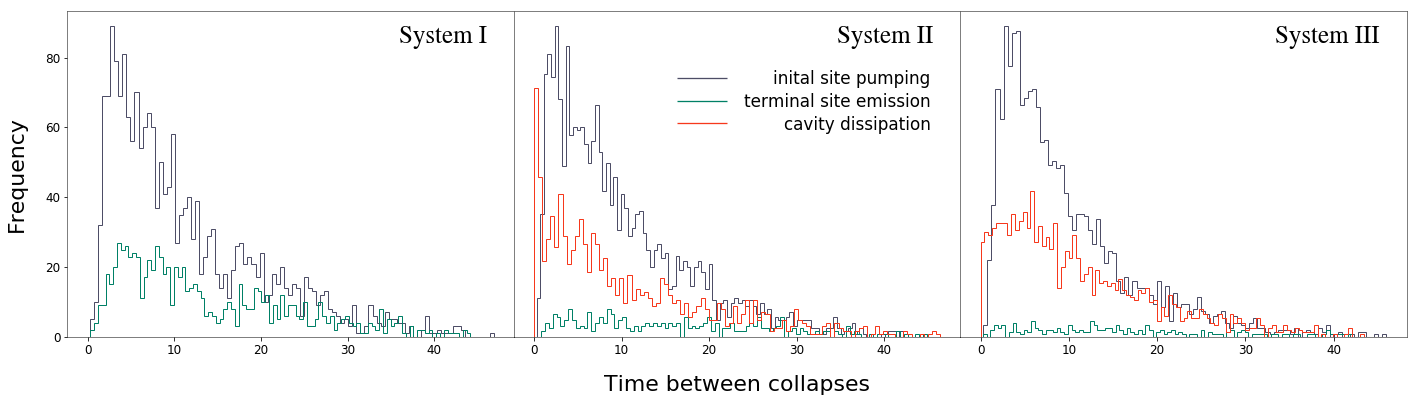

In [41]:
PlotStyle()
histopts = {'bins':100, 'histtype':'step'}
histcolor_list = [colors[5],  (0.00,0.5,0.4), colors[4]]
for cfunc in [cfunc1,cfunc2,cfunc3]: cfunc.colors = histcolor_list
with plt.rc_context({'axes.labelsize':22}):
    fig, ax = plt.subplots(1,3, figsize = (8*3, 6))
    plt.subplots_adjust(wspace = 0)
    _ = [cfunc.PlotWaitTimes(ax[i], histopts) for i, cfunc in enumerate([cfunc1,cfunc2,cfunc3])]
[ax[i].get_legend().remove() for i in [0,2]]
[ax[i].tick_params(left = False, labelleft = False) for i in [1,2]]
[ax[i].set_ylabel("") for i in [1,2]]
[ax[i].set_xlabel("") for i in [0,2]]
legend = ax[1].legend(loc = (.35,0.6), handlelength = 3, handleheight = 0, labelspacing = 0.3)
for ind,label in enumerate(legend.get_texts()):
    label.set_ha("right")
    label.set_position((190,0))
    y_old = legend.get_patches()[ind].get_y()
    legend.get_patches()[ind].set_height(0)
    legend.get_patches()[ind].set_lw(1.3)
    legend.get_patches()[ind].set_y(y_old+2+ind*.5)
    
_ = [plt.text(0.94,0.9,"System %s"%["I", "II", "III"][i], transform = ax[i].transAxes,\
              fontname = 'StixGeneral', fontsize = 25, fontweight = 500, horizontalalignment = 'right') for i in range(3)] 

plt.savefig("posterplots/waithists.png")

## Time Dependent $\gamma_P$ : *Exponential Decay*

<br>**check** : pdict does not matter her (specifically J)<br><br>

In [42]:
def pcol_coeff(t, args):
    return 10*1.1**(-t)
t = np.linspace(0,100,400)

In [14]:
tdepII = PhotoDetector()
tdepII.GetInfo()
tdepII.TDepPump(pcol_coeff)
resultII = tdepII.expectH(t, verbose = True, odeopts = {'store_states':True, 'average_states':True})

tdepIII = PhotoDetector(kind = 'III')
tdepIII.GetInfo()
tdepIII.TDepPump(pcol_coeff)
resultIII = tdepIII.expectH(t, verbose = True, odeopts = {'store_states':True, 'average_states':True})

N                       6
M                       10
Jx                      [0.628, ....]
Jy                      [0.628, ....]
Jz                      [0.000, ....]
gamma                   [0.  0.  0.  0.  0.  0.1]
pump                    [0.1 0.  0.  0.  0.  0. ]
num spin collapse ops   3
num return ops          7
H dims                  (640, 640)
coupling, g             0.5
kappa                   0.3
solving with options. Dictionary: {'store_states': True, 'average_states': True}
10.0%. Run time:   7.54s. Est. time left: 00:00:01:07
20.0%. Run time:  13.17s. Est. time left: 00:00:00:52
30.0%. Run time:  18.37s. Est. time left: 00:00:00:42
40.0%. Run time:  23.69s. Est. time left: 00:00:00:35
50.0%. Run time:  29.43s. Est. time left: 00:00:00:29
60.0%. Run time:  34.57s. Est. time left: 00:00:00:23
70.0%. Run time:  40.39s. Est. time left: 00:00:00:17
80.0%. Run time:  45.44s. Est. time left: 00:00:00:11
90.0%. Run time:  51.17s. Est. time left: 00:00:00:05
100.0%. Run time:  56.6

In [20]:
# qsave(tdepIII, "tdepIII")
# qsave(tdepII, "tdepII")
# qsave(resultIII, "resultIII")
# qsave(resultII, "resultII")
LtdepIII = qload("tdepIII")
LtdepII = qload("tdepII")
LresultIII = qload("resultIII")
LresultII = qload("resultII")

Loaded PhotoDetector object.
Loaded PhotoDetector object.
Loaded Result object:
Result object with mcsolve data.
--------------------------------
states = True
num_collapse = 3, ntraj = 500
Loaded Result object:
Result object with mcsolve data.
--------------------------------
states = True
num_collapse = 3, ntraj = 500


In [43]:
#plot function
PlotStyle()
def PlotFunc(sys,expt, ax, ax2 = None, t = np.linspace(0,50,200), color = (0.5,0.1,0.5), label = "",\
            xtextoffset = 0, ytextoffset=0, args = {}, GetPeakT = False): 
    if(ax2 == None): ax2 = ax #either on two axes or one 
    pumpcurve = sys.c_ops[-1][1](t, args)
    peakI = np.argmax(expt)
    peakP = expt[peakI]
    peakT = t[peakI]
    # plot photon count and collapse op function
    ax.plot(t, expt, color = color, label = label) 

    pumpcurve = sys.c_ops[-1][1](t, args)
    ax2.plot(t, pumpcurve, color = (0,0,0))

    # mark peak cavity expectation (point and vertical line)
    poptim = pumpcurve[peakI]
    ax2.scatter(peakT, poptim, color = color)
    ax2.text(peakT*1.1+xtextoffset,peakP*1.1+ytextoffset, "$\gamma_P$ = %.3f"%poptim, fontsize = 12)
    if ax2!=ax: ax2.axvline(x = peakT, ymin = 0, ymax = 200, linestyle = '--', color = color, alpha = .5, lw = 1.5)
    ax.axvline(x = peakT, ymin = 0, ymax = 200, linestyle = '--', color = color, alpha = .5, lw = 1.5)

    # bling
    ax2.set_ylabel(r"Pump rate, $\gamma_P$")
    ax.set_ylabel(r"Photon Count, $\langle a^{\dagger} a\rangle$")
    ax.set_xlabel("time $\mathrm{(\hslash/\omega)}$")
    if ax2!=ax:
        plt.subplots_adjust(hspace = 0)
        ax2.tick_params('x', bottom = False, labelbottom = False)
    else: ax2.set_xlabel("time $(\hslash/\omega)$")
    if(GetPeakT): return peakT

In [25]:
    
# colorII = (0.8,0.1,0.1); colorIII = (0.1,0.1,0.7)
# exptII = resultII.expect[-1] # cavity expectation for II
# exptIII = resultIII.expect[-1] # cavity expectation for III
# fig, ax = plt.subplots(2, figsize = (15,10))

# PlotFunc(tdepII, exptII, ax[1], ax2 = ax[0], t = t, color = colorII, label = "System II")
# PlotFunc(tdepIII, exptIII, ax[1], ax2 = ax[0], t = t, color = colorIII, label = "System III")

# legfont = matplotlib.font_manager.FontProperties(family='cmr10',
#                                    weight='bold',
#                                    style='normal', size=16)
# ax[1].legend(prop= legfont)
# #plt.text(-10,-.7, "Cavity Occupation for systems with time-dependent pump rate. \nPump rates for peak photon intensity are unique to the photodetector model.")
# plt.show()

In [27]:
# statesIII = resultIII.states
# statesII = resultII.states
# fig,ax = plt.subplots(1,3,figsize = (15,5))
def plotfunc_wigner(xvec,rho_cav, ax,  cbshow = False):
    minp = 0; maxp = .5; 
    W = wigner(rho_cav, xvec, xvec)
    norm = mpl.colors.Normalize(vmin = 1e-5, vmax = .5)
    cf = ax.contourf(xvec, xvec, W, 100, cmap = cm.bone_r,levels = 300,norm = norm)
    if (cbshow): cb = plt.colorbar(cf,ax = ax, format = '%.2f', orientation = 'horizontal')
    else: return cf
# xvec = np.linspace(-7,7,100)  
# cf1 = plotfunc_wigner(xvec,statesII[0].ptrace(6), ax[0])
# cf2 = plotfunc_wigner(xvec,statesII[115].ptrace(6), ax[1])
# cf3 = plotfunc_wigner(xvec,statesIII[115].ptrace(6), ax[2])
# fig.colorbar(cf1,ax = ax)

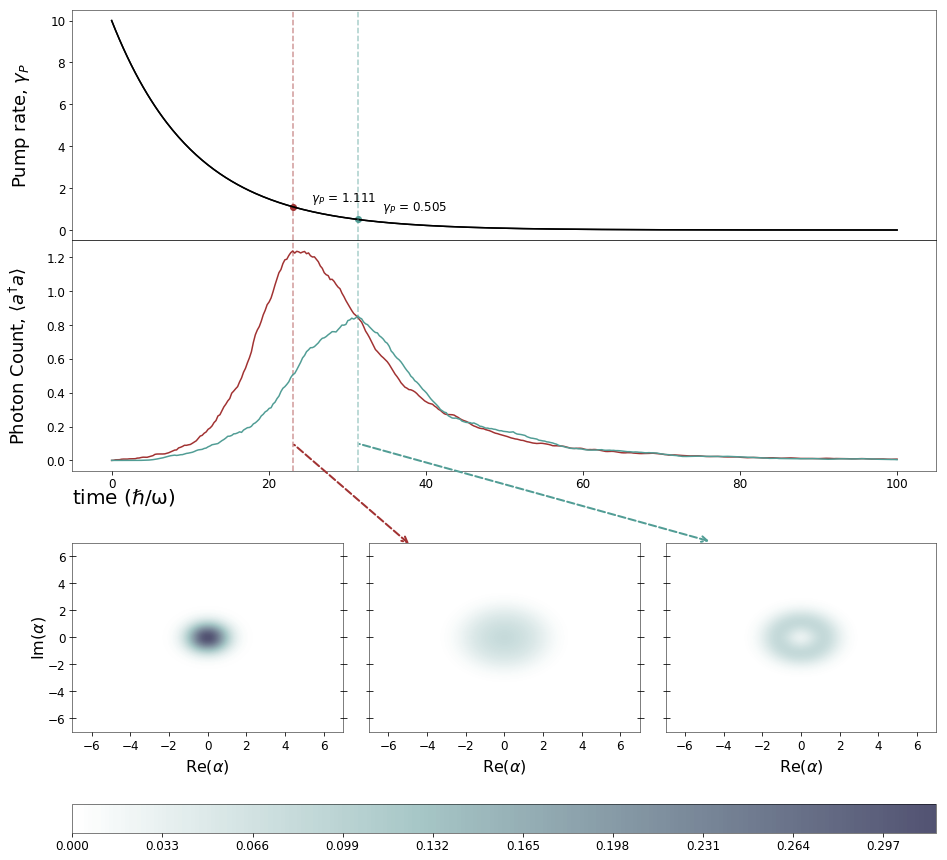

In [48]:
t = np.linspace(0,100,400)
# set up figure axes
Fig = plt.figure()
bigh =.8; bigw = 2
lspace = .03
lilw = (bigw-lspace)/3; lilh = lilw;
vspace = .25
cbwidth = lilw*3+lspace
cbheight = 0.1

A1 = Fig.add_axes([0,   lilh+vspace,   bigw,   bigh])
A2 = Fig.add_axes([0.,   lilh+vspace+bigh,   bigw,   bigh])
a1 = Fig.add_axes([0.0,   0.0,    lilw-lspace,      lilh])
a2 = Fig.add_axes([lilw+lspace,   0.0,    lilw-lspace,      lilh])
a3 = Fig.add_axes([(lilw+lspace)*2,   0.0,    lilw-lspace,      lilh])
cbax = Fig.add_axes([0,   -cbheight-0.25,    cbwidth,      cbheight])

# plotted variables
sysII = LtdepII #Class instance (necessary for retrieving c_op function)
sysIII = LtdepIII
exptII = LresultII.expect[-1] # cavity expectation
exptIII = LresultIII.expect[-1] 
statesII = LresultII.states  #states
statesIII = LresultIII.states 
xvec = np.linspace(-7,7,100) # for wigner function
colourII = (161/255,50/255,50/255); colourIII = (90/285,176/285,167/285)

# Create Plots
pT1 = PlotFunc(sysII, exptII, A1, ax2 = A2, t = t, color = colourII, label = "System II", GetPeakT=True)
pT2 = PlotFunc(sysIII, exptIII, A1, ax2 = A2, t = t, color = colourIII, label = "System III", GetPeakT=True)

cf1 = plotfunc_wigner(xvec,statesII[0].ptrace(6), a1)
cf2 = plotfunc_wigner(xvec,statesII[115].ptrace(6), a2)
cf3 = plotfunc_wigner(xvec,statesIII[115].ptrace(6), a3)

#draw arrows 
A1.annotate("", xy=(pT1, .1), xytext=(pT1+15, -.5), arrowprops={'arrowstyle':'<-', 'color':colourII, 'lw':2, "linestyle":"--"},
            annotation_clip = False)
A1.annotate("", xy=(pT2, .1), xytext=(pT2+45, -.48), arrowprops={'arrowstyle':'<-', 'color':colourIII, 'lw':2, "linestyle":"--"}, annotation_clip = False)



#move x axis label 
A1.set_xlabel(""); plt.text(0.00,-0.14,"time $\mathrm{(\hslash/\omega)}$", transform = A1.transAxes, fontsize = 20)
#other labels
_ = [a.set_xlabel(r"$\mathrm{Re}(\alpha)$", labelpad = 5, fontsize = 16) for a in [a1,a2,a3]]
_ = [a.set_ylabel(r"$\mathrm{Im}(\alpha)$", labelpad = 0, fontsize = 16) for a in [a1]]
_ = [a.tick_params(axis = 'y',labelleft = False, direction = 'inout', length = 7) for a in [a2,a3]]
_ = [a.tick_params(axis = 'y', right = True, direction = 'inout', length = 7) for a in [a1,a2]]

Fig.colorbar(cf1,cax = cbax, ax = [a1,a2,a3], orientation = 'horizontal')

plt.savefig("posterplots/decaypulse.png", bbox_inches = 'tight')




## Time Dependent $\gamma_P$ : *Gaussian Pulse*

In [30]:
def pcol_coeff_gauss(t, args):
    a = args['A'] #curve amplitude
    b = args['xmid'] #position of center of peak
    c = args['w'] #curve width (s.d.)
    return a*np.exp(-(t-b)**2/(2*c**2))

In [31]:
LlistsysII = qload("listsysII")
LlistsysII = qload("listsysIII")
Larglist = qload("arglist")
Lr_II = qload("r_II")
Lr_III = qload("r_III")

Loaded list object.
Loaded list object.
Loaded list object.
Loaded list object.
Loaded list object.


In [33]:
#results = result[Amplitude][width]
def func_plotAexpts(i_width, axes):
    for i, A in enumerate(amp_list):
        colorVal = scalarMap.to_rgba(A)
        ax1lines, = axes[0][i_width].plot(t, Lr_II[i][i_width].expect[-1], label = "%.1f"%A, color = colorVal) 
        axes[1][i_width].plot(t, Lr_III[i][i_width].expect[-1], label = "%.1f"%A, color = colorVal) 
        axes[2][i_width].plot(t,pcol_coeff_gauss(t, args = {'A':A, 'w':w_list[i_width], 'xmid':100}), color = colorVal)
    plt.text(.75,.85, "w = %.1f"%w_list[i_width], transform = axes[0][i_width].transAxes, fontsize = 18)

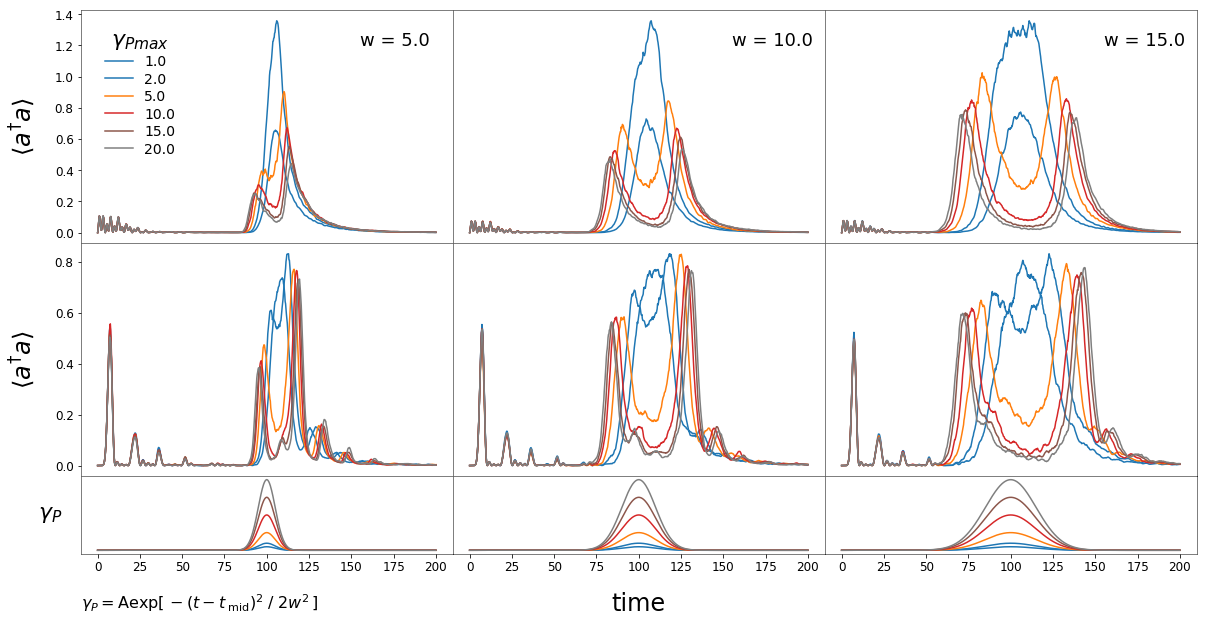

In [53]:
PlotStyle()
# pick colormap
cmap = 'tab10'
cNorm  = mpl.colors.Normalize(vmin=.9, vmax=25.)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

fig, ax = plt.subplots(3,3,figsize = (20,10), gridspec_kw={'height_ratios': [3, 3,1]})
plt.subplots_adjust(hspace = 0, wspace = 0)

[ax[2][j].tick_params(left = False, labelleft = False) for j in range(3)] # no pulse y ticks
[ax[i][j].tick_params(left = False, labelleft = False) for i in [0,1] for j in [1,2]] # no expt y ticks

# axis labels
[ax[i][0].set_ylabel(r"$\langle a^{\dagger} a \rangle$", fontsize = 24) for i in range(2)]
ax[2][0].set_ylabel("$\gamma_P$", rotation = 0, fontsize = 22, verticalalignment = 'center',\
                     horizontalalignment = 'right')
ax[2][1].set_xlabel("time", fontsize = 24)

# mcsolve input
t = np.linspace(0,200,800)
args = {'A': 10,
       'xmid': 100,
       'w': 10}
amp_list = [1,2,5,10,15,20]
w_list = [5,10,15]

# plot 
func_plotAexpts(0, ax)
func_plotAexpts(1, ax)
func_plotAexpts(2, ax)
# toys
leg = ax[0][0].legend(loc = (0.05,.35), fontsize = 14, title = r"$\gamma_{Pmax}$", title_fontsize = 22,labelspacing = .25)
plt.text(0,-.7,'$\gamma_P=\mathrm{A}\exp{[\,-(t-t_{\;\mathrm{mid}})^2\;/\;2w^2\,]}$', fontsize = 16, transform = ax[2][0].transAxes,\
        horizontalalignment = 'left')


plt.savefig("posterplots/gausspulse.png", bbox_inches = 'tight')
plt.show()


In [285]:
# i need 6 colors
import matplotlib.cm as cmx
colors = [(0.03622706206371584, 0.34758778627580533, 0.01986544244584898), #dark green
         (0.6053728047696756, 0.12285060981191465, 0.33668767700053526), #dark red
         (0.2962116999036982, 0.32094848866668646, 0.9759888514083577), #pretty blue
         (0.039492199876027034, 0.6074865840810965, 0.5673421818210376), #pretty teal
         (0.9664233468923764, 0.22096743571225297, 0.11020477132985629), #coral
         (0.3,0.3,0.4)] #gray



cNorm  = mpl.colors.Normalize(vmin=0, vmax=6)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='Set3')

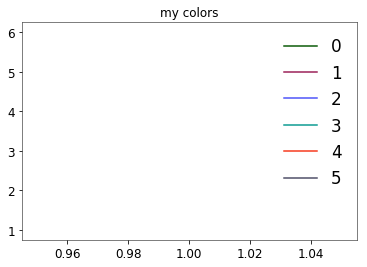

In [387]:
#colorlist_temp = []
for i in range(6):
    rcolor = (rand.random(), rand.random(), rand.random())
    plt.plot(np.ones(10),np.ones(10)*i+1., color = colors[i], label = "%d"%i)
    colorlist_temp.append(rcolor)
plt.title("my colors")
plt.legend()

In [260]:
colorlist_temp

[(0.32290418310660585, 0.6934448121183102, 0.3439217431002288),
 (0.0279440056554755, 0.03651403748365589, 0.03706424691824872),
 (0.49488917427527745, 0.22515145217953902, 0.44043052330086285),
 (0.689246003608747, 0.016756251128121957, 0.46435498336139724),
 (0.3409592964789976, 0.2663673624971704, 0.38850875836695886),
 (0.9664233468923764, 0.22096743571225297, 0.11020477132985629),
 (0.5036312902290385, 0.9674256655342668, 0.4980259667227749),
 (0.011153633231270388, 0.6926898737870909, 0.4614640986239159),
 (0.37303140887878206, 0.2128599384685561, 0.5144530519037263),
 (0.5881434145034425, 0.4849115914956217, 0.12301406107413215)]

In [368]:
import matplotlib as mpl
mpl.rcParams.keys()

/home/golin/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        